<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/efficient_sampled_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficient Sampled Softmax

This code simplifies and optimizes the default TF sampled softmax loss.
The speedup in training can be by a factor of 2 for NLP tasks.

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

def sampled_softmax_loss(target_embed_kernel,labels,inputs_embed,
                         samples,labels_prior,samples_prior,
                         gradient_shapes=None):
  '''
    computes sampled softmax loss, more efficient than TF implementation
    inputs: 
    - class embeddings [N_BATCH,N_EMBED]
    - true labels [N_BATCH]
    - embeded inputs [N_BATCH,N_EMBED]
    - sampled candidates with sampling priors 
      triple (samples,labels_prior,samples_prior) as computed by candidate sampler from tf)
    - [optional] dense shapes for gradients 
    outputs: 
    - loss, scalar - mean over batch!
    - [optional] gradients for embeddings in sparse form!, when shapes passed
  '''
  with tf.variable_scope('sampled_softmax'):

    with tf.variable_scope('target_embeddings'):
      samples_embed = tf.gather(target_embed_kernel,samples) # (N_SAMPLED,N_EMBED)
      labels_embed = tf.gather(target_embed_kernel,labels,axis=0) # (N_BATCH,N_EMBED)

    with tf.variable_scope('labels_logits'):
      labels_logits = tf.matmul(tf.expand_dims(labels_embed,1),tf.expand_dims(inputs_embed,-1)) # (N_BATCH,1,1)
      labels_logits = tf.squeeze(labels_logits,-1) # N_BATCH,1
      labels_logits = labels_logits-tf.log(labels_prior) # add prior-correction

    with tf.variable_scope('sampl_logits'):
      samples_logits = tf.matmul(inputs_embed,samples_embed,transpose_b=True) # (N_BATCH,N_SAMPLED)
      samples_logits = samples_logits-tf.log(samples_prior) # add prior-correction
      
    with tf.variable_scope('sampl_loss'):
      candidate_logits = tf.concat([samples_logits,labels_logits],axis=-1) # (N_BATCH,N_SAMPLED+1)
      Z = tf.reduce_logsumexp(candidate_logits,axis=-1,keepdims=True) # (N_BATCH,1)
      loss = tf.reduce_mean(-labels_logits+Z)

    if not gradient_shapes:
      return loss 
    else:
      with tf.variable_scope('backprop'):
        # note: gradients computed as sparse slices (tf.IndexedSlice), indices may duplicate
        grad_input_embed_shape,grad_target_embed_shape = gradient_shapes
        batch_len = tf.cast(tf.shape(labels)[0],tf.float32)
        samples_pred = tf.exp(samples_logits-Z)/batch_len # (N_BATCH,N_SAMPLED)
        samples_mass = tf.reduce_sum(samples_pred,axis=-1,keepdims=True) # (N_BATCH,1)

        with tf.variable_scope('grad_input_embed'):
          grad_input_embed = tf.matmul(samples_pred,samples_embed) # (N_BATCH,N_EMBED)
          grad_input_embed = grad_input_embed - samples_mass * labels_embed 
          grad_input_embed = tf.IndexedSlices(grad_input_embed, inputs, grad_input_embed_shape)

        with tf.variable_scope('grad_target_embed'):
          grad_target_embed1 = tf.matmul(samples_pred,inputs_embed,transpose_a=True) # (N_SAMPLED,N_EMBED)
          grad_target_embed2 = -samples_mass * inputs_embed # (N_BATCH,N_EMBED)
          grad_target_embed = tf.concat([grad_target_embed1,grad_target_embed2],0) # (N_BATCH+N_SAMPLED,N_EMBED)
          grad_target_embed = tf.IndexedSlices(grad_target_embed, tf.concat([samples,labels],0), grad_target_embed_shape)

      return loss,grad_input_embed,grad_target_embed

TensorFlow 1.x selected.


# Test correctness

We tests loss and backpropagation on random data several times.

In [2]:
tf.reset_default_graph()
import numpy as np

## random data to check correctness, synthetic word2vec problem

N_BATCH = 32
N_WORDS = 100000
N_EMBED = 300
N_SAMPLED = 100

inputs = tf.placeholder(tf.int64,[None])
labels = tf.placeholder(tf.int64,[None])

input_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32)
target_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32)
target_embed_bias = tf.zeros(N_WORDS)
inputs_embed = tf.gather(input_embed_kernel,inputs) # (N_BATCH,N_EMBED)

samples,labels_prior,samples_prior = tf.random.uniform_candidate_sampler(tf.expand_dims(inputs,-1),1,N_SAMPLED,False,N_WORDS)

## our optimized loss
loss,grad_input,grad_target = sampled_softmax_loss(target_embed_kernel,
                          labels,inputs_embed,
                          samples,labels_prior,samples_prior,
                          [tf.shape(input_embed_kernel),tf.shape(target_embed_kernel)])                          
grads = [grad_input,grad_target]

## tensorflow loss - note it is not reduced accross batch
loss_tf = tf.nn.sampled_softmax_loss(target_embed_kernel,target_embed_bias,
                                  labels,inputs_embed,
                                  N_SAMPLED,N_WORDS,1,
                                  (samples,labels_prior,samples_prior),
                                  False)

loss_tf = tf.reduce_mean(loss_tf)
grads_auto = tf.gradients(loss,[input_embed_kernel,target_embed_kernel])
grads_tf = tf.gradients(loss_tf,[input_embed_kernel,target_embed_kernel])

init_randomness = tf.global_variables_initializer()

with tf.Session() as sess:
  for _ in range(3):
    # refresh randomness every time
    sess.run(init_randomness)
    inputs_batch,labels_batch = np.random.randint(0,10,[2,N_BATCH],np.int64)
    feed_dict = {inputs:inputs_batch,labels:labels_batch}
    # compute both losses and compare
    loss1,loss2 = sess.run([loss_tf,loss],feed_dict)
    np.testing.assert_array_almost_equal(loss1,loss2,5)
    # compute gradients and compare
    grad1,grad2,grad1_auto,grad2_auto = sess.run(grads+grads_auto,feed_dict)
    for i in range(3):
      np.testing.assert_array_almost_equal(grad1[i],grad1_auto[i],5)
      np.testing.assert_array_almost_equal(grad2[i],grad2_auto[i],5)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Compare speed

We evaluate speed of both implementations for forward and backward passes. Time is in seconds.

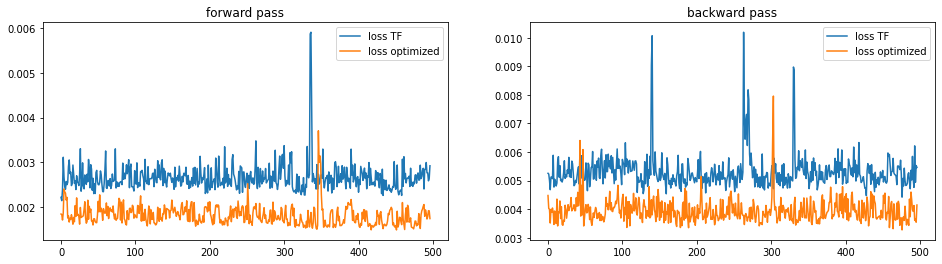

In [5]:
import time
from matplotlib import pyplot as plt

N_BATCH = 256

train_data = np.random.randint(0,10,[500,2,N_BATCH],np.int64)

def get_timings(op,train_data):
  ''' does timings for a graph op several times '''
  with tf.Session() as sess:
    sess.run(init_randomness)
    times = []
    for inputs_batch,labels_batch in train_data:
      feed_dict = {inputs:inputs_batch,labels:labels_batch}
      time_start = time.time()
      sess.run(op,feed_dict)
      time_end = time.time()
      times.append(time_end-time_start)
  return np.array(times)

_,axs=plt.subplots(1,2,figsize=(16,4))

## evaluate forwad pass

for op,label in zip([loss_tf,loss],['loss TF','loss optimized']):
  timings = get_timings(op,train_data)  
  axs[0].plot(timings[3:],label=label)
axs[0].legend()
axs[0].set_title('forward pass')

## evaluate backward pass

for op,label in zip([grads_tf,grads],['loss TF','loss optimized']):
  timings = get_timings(op,train_data)  
  axs[1].plot(timings[3:],label=label)
axs[1].legend()
axs[1].set_title('backward pass')

plt.show()